# Intro
This notebook implements a Jupyter directory browser widget using [ipydatagrid](https://github.com/bloomberg/ipydatagrid):
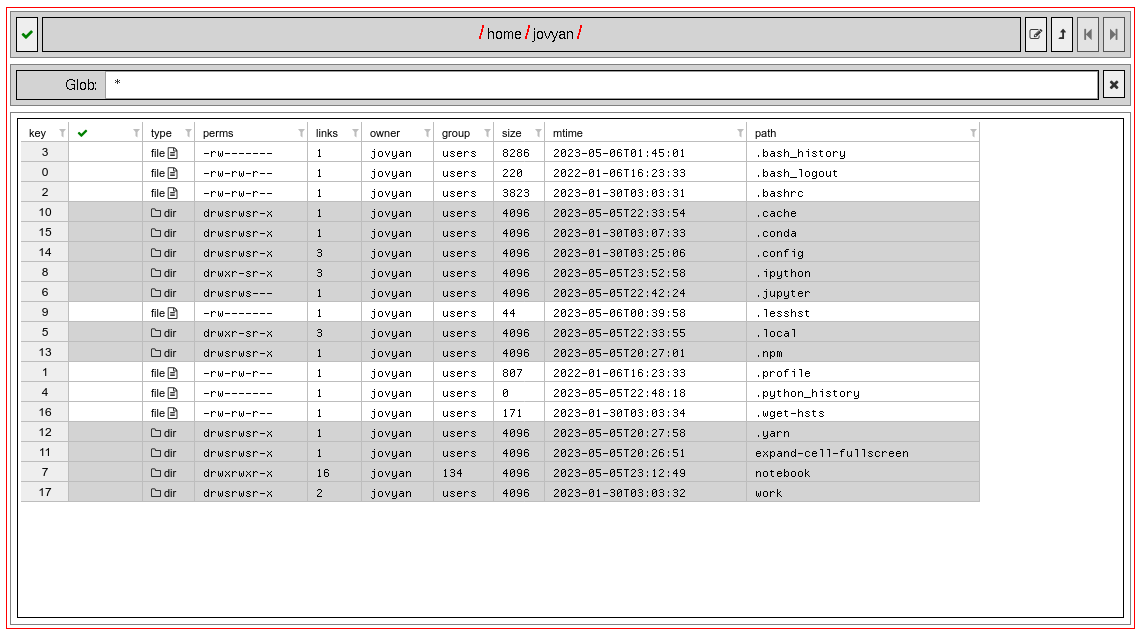


## Overview
The directory browser is implemented in a class named **filepaths_table** which is subclassed from **ipywidgets.VBox** so you can use it anywhere that you would use an IPython VBox widget.

To select paths, click on the column with the green check mark in the header.

To make use of the file selections chosen within the widget, pass your callback function into the widget's **set_selection_callback()** method.  Your function should accept a single argument, which will be a list of strings for the paths that have been selected.  Your function is called when the button in the top left, with the green check, box is clicked.  If you don't pass a callback function, the default callback just prints the selected paths.

## Installation and usage
If you use the **[ipynb](https://ipynb.readthedocs.io/en/stable/)** module, you can import this whole notebook as if it were a Python module like this:

```python
import ipynb
from ipynb.fs.defs.directory_browser_using_ipydatagrid import *
```

and then you can create a directory browser widget like this:
```python
fpt = filepaths_table(initial_path="/usr/local/bin")
fpt
```

You can install this notebook as a library like this:

```pip install 'git+https://github.com/mister-average/directory_browser_using_ipydatagrid.git'```

## Code organization
In this notebook, the class definition for **filepaths_table** is split across multiple cells with Markdown cells sprinkled between the code cells in order to provide documentation.  This is accomplished by using a trick that was attributed to [Dr. Doug Blank](https://www.linkedin.com/in/douglasblank/).  The trick is that in each cell you subclass the original class and add extra functionality as you go.

# imports

In [ ]:
import ipywidgets, os, glob, stat, pwd, grp, sys

In [ ]:
import IPython

In [ ]:
from IPython.display import display, HTML

In [ ]:
from ipydatagrid import DataGrid, TextRenderer, BarRenderer, VegaExpr, Expr
from traitlets import Any, Bool, Enum, Float, Instance, Unicode, Union, validate
import pandas as pd
from py2vega import *
import gast

In [ ]:
from py2vega.main import VegaExpressionVisitor

In [ ]:
import pprint

In [ ]:
from functools import lru_cache

In [ ]:
from itertools import cycle

# Fixing glob()
The following is needed because versions of the glob module in python 3.10 and below will never show hidden files.

In [ ]:
def nothing_is_hidden(path):
    return False

if sys.version_info.minor < 11:
    glob._ishidden = nothing_is_hidden

# Fixing py2vega()
ipydatagrid supports using Vega expressions for formatting, and also can convert simple python code into Vega expressions.

The following are needed because py2vega uses the inspect module's getsource() function, which cannot parse Python code sitting in a notebook (as opposed to Python code sitting in a normal .py text file).

In [ ]:
def py2vega_without_inspect(value, whitelist=[]):
    """Convert Python code or Python function to a valid Vega expression."""
    func = gast.parse(value, '<string>', 'exec').body[0]

    scope = {}
    for node in func.body[:-1]:
        VegaExpressionVisitor(whitelist, scope).visit(node)
    return VegaExpressionVisitor(whitelist, scope).visit(func.body[-1])

The normal usage of Vega expressions with **ipydatagrid** is to define a Python function and then pass that function directly as an argument to **Expr()**.  Expr() would then end up getting the Python code using inspect.getsource() and then convert that code into a Vega expression.  

This alternate usage passes a string which contains a Python function definition as an argument to **Expr_without_inspect()**.  The return value from Expr_without_inspect() can be used like the return value from Expr()

In [ ]:
class Expr_without_inspect(VegaExpr):
    value = Any().tag(sync=True)

    @validate("value")
    def _validate_value(self, proposal):
        return py2vega_without_inspect(
            proposal["value"],
            [
                Variable("cell", ["value", "row", "column", "metadata"]),
                "default_value",
                "index",
            ],
        )

# class filepaths_table

## &#95;&#95;init&#95;&#95;()
Note that every time we enter into a new directory and obtain a directory listing, that listing is stored in self.path_listing_df, a Pandas dataframe, and that dataframe is given to ipydatagrid for display.

In [ ]:
class filepaths_table(ipywidgets.VBox):
    def __init__(self, *args, initial_path = None, **kwargs):
        if initial_path is None:
            initial_path = os.getcwd()
        
        display(HTML("""
<style>
.hbox_style{
    background-color:lightgray;
}
</style>"""))
        
        # Every navigation will change these values.  But to set the current directory, you must call set_current_directory
        self.current_directory = initial_path
        self.directory_history = []
        self.directory_history_index = -1
        self.path_listing_df = None
        self.datagrid = None
        self.saved_column_widths = None
        
        self.selection_callback = self.default_selection_callback
        
        self.create_row_1()
        self.create_row_2()
        self.create_row_3()
        
        ipywidgets.VBox.__init__(self, [self.row1, self.row2, self.row3], layout=ipywidgets.Layout(border="1px solid red") )        

## Create the rows of the GUI

### create_row_1(self) - buttons and path

#### Selection callback button


<br><center>This button calls your callback and passes the list of selected paths</center>

#### Path display / path editor

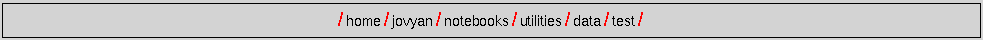
<br>The path display uses big red slashes to delimit the path components.

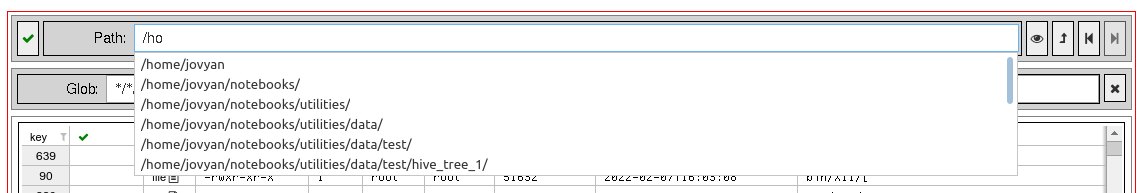
<br>The path editor has a history of paths that were manually entered.

#### Toggle path edit button


<br><center>This button toggles the edit mode of the path display / path editor that is to the left of this button.</center>

#### Go up button


<br><center>This button navigates up one directory</center>

#### Go back button


<br><center>This button navigates to the previous directory</center>

#### Go forward button


<br><center>This button navigates back forward IF you have navigated back in your history list</center>

In [ ]:
class filepaths_table(filepaths_table):
    def create_row_1(self):
        ##############################################################################################################################
        # ROW 1: Path display and navigation
        # Just a simple button that executes a callback against the selection list
        self.select_button = ipywidgets.Button(icon='check', tooltip='Accept the current selections',
                                               style=dict(
                                                text_color='green'
                                            ),
                                             layout=ipywidgets.Layout(
                                                 min_height='35px',
                                                  display="flex", 
                                                  align_items="center",
                                                  align_content="center",
                                                  justify_content="center",
                                                    border="1px solid black",
                                                    flex="0 0 0%", width="auto"
                                             ))
        self.select_button.on_click(self.selection_callback_pre)
        
        
        
        # We toggle between the following two widgets to display/edit the path
        if True:
            self.current_directory_label = ipywidgets.HTML(value='', 
                                                           layout=ipywidgets.Layout(overflow_x='auto'))
            self.set_current_directory_label_value(self.current_directory)

            self.enter_directory_combo = ipywidgets.Combobox(description='Path:', ensure_option=False, 
                                                             options=[self.current_directory],
                                                             value=self.current_directory, 
                                                             layout=ipywidgets.Layout(overflow_x='auto',
                                                                           flex='3 1 auto', 
                                                                           align_items="flex-start",
                                                                           width='auto'))
            self.enter_directory_combo.observe(self.enter_directory_combo_value_changed, names='value')

        # We use this stack widget to toggle between the two above widgets
        self.path_stack = ipywidgets.Stack([self.current_directory_label, self.enter_directory_combo], selected_index=0,
                                           layout=ipywidgets.Layout(
                                                              display="flex", 
                                                              align_items="center",
                                                              align_content="center",
                                                              justify_content="center",
                                                    margin="2px",
                                                    border="1px solid black",
                                                    flex='3 1 auto', width='auto'
                                            )
                                          )
        
        # We control the path stack widget using this toggle button
        self.toggle_path_stack_button = ipywidgets.Button(icon='edit',
                                                          tooltip = 'Edit the path',
                                                          layout=ipywidgets.Layout(
                                                 min_height='35px',
                                                              display="flex", 
                                                              align_items="center",
                                                              align_content="center",
                                                              justify_content="center",
                                                              border="1px solid black",
                                                              flex="0 0 0%", width="auto"
                                                          ))
        self.toggle_path_stack_button.on_click(self.toggle_path_stack)
        
        
        # Just a simple button that takes us up one directory
        self.up_button = ipywidgets.Button(icon='level-up', tooltip='Navigate to parent folder', 
                                           layout=ipywidgets.Layout(
                                                 min_height='35px',
                                                  display="flex", 
                                                  align_items="center",
                                                  align_content="center",
                                                  justify_content="center",
                                                    border="1px solid black",
                                                    flex="0 0 0%", width="auto"
                                            ))
        self.up_button.on_click(self.set_directory_to_parent)

        # Just a simple button that takes us back to the previous directory
        self.back_button = ipywidgets.Button(icon='step-backward', tooltip='Navigate to previous folder', disabled=True,
                                             layout=ipywidgets.Layout(
                                                 min_height='35px',
                                                  display="flex", 
                                                  align_items="center",
                                                  align_content="center",
                                                  justify_content="center",
                                                    border="1px solid black",
                                                    flex="0 0 0%", width="auto"
                                             ))
        self.back_button.on_click(self.go_back_one_directory)

        # Just a simple button that takes us forward to the next directory
        self.forward_button = ipywidgets.Button(icon='step-forward', tooltip='Navigate to next folder', disabled=True,
                                                layout=ipywidgets.Layout(
                                                 min_height='35px',
                                                  display="flex", 
                                                  align_items="center",
                                                  align_content="center",
                                                  justify_content="center",
                                                    border="1px solid black",
                                                    flex="0 0 0%", width="auto"
                                                ))
        self.forward_button.on_click(self.go_forward_one_directory)



        self.row1 = ipywidgets.HBox((self.select_button,
                                     self.path_stack, 
                                     self.toggle_path_stack_button, 
                                     self.up_button,
                                     self.back_button,
                                     self.forward_button),
                                     style={'background': 'blue'},
                                     layout=ipywidgets.Layout(
                                                  display="flex", 
                                         align_items='stretch',
                                         align_content='stretch',
                                         padding="3px",
                                         margin="3px",
                                         border="1px solid gray",
                                         justify_content='space-around'
                                    )
                                   )

        self.row1.add_class("hbox_style")
        

### create_row_2(self) - glob pattern
You can only select from the paths that are visible.  If you switch directories, all your previous selections are cleared.  If you need to select paths that span across different directories, set a glob pattern in this box, and the display will show all paths that match your glob pattern (relative to the current directory).

In [ ]:
class filepaths_table(filepaths_table):
    def create_row_2(self):
        ##############################################################################################################################
        # ROW 2: Path glob filter
        self.glob_combo = ipywidgets.Combobox(description='Glob:', ensure_option=False, value='*',
                                             layout = ipywidgets.Layout(
                                                border="1px solid black",
                                                flex='3 1 auto', width='auto'
                                             ))
        self.glob_combo.observe(self.glob_combo_value_changed, names='value')

        self.clear_glob_button = ipywidgets.Button(icon='close', tooltip='Clear the glob pattern',
                                                  layout = ipywidgets.Layout(
                                                  display="flex", 
                                                  align_items="center",
                                                  align_content="center",
                                                  justify_content="center",
                                                    border="1px solid black",
                                                    flex="0 0 0%", width="auto"
                                                  ))
        self.clear_glob_button.on_click(self.clear_glob)



        self.row2 = ipywidgets.HBox((self.glob_combo, self.clear_glob_button),
                                     layout=ipywidgets.Layout(
                                         align_items='stretch',
                                         padding="3px",
                                         margin="3px",
                                         border="1px solid gray",
                                        justify_content='space-around'
                                    )
                                   )

        self.row2.add_class("hbox_style")
        

### create_row_3(self) - grid widget
For me, the **auto_fit_columns** feature did not work at any other time than during initialization (other people have [reported](https://github.com/bloomberg/ipydatagrid/issues/302) this too).  If ipydatagrid's dataframe was replaced, the column widths would immediately fall back to all having an identical size, which was too short to display most columns.

The way around this was to create a new ipydatagrid every time we switched directories.  This was done by wrapping the ipydatagrid widget in an Output widget, and calling the Output widget's clear_output() method, and then creating a new ipydatagrid using the Output widget context manager.  This workaround happens in the **update_gui()** method below.

In [ ]:
class filepaths_table(filepaths_table):
    def create_row_3(self):
        ##############################################################################################################################
        # ROW 3: The data grid
        
        self.selection_header_click_action = cycle(['select all', 'deselect all'])
        
        self.generate_path_listing_df()

        only_color_check_header_green_str = '''
def only_color_check_header_green(cell):
    if cell.value == "selected":
        return "green"
    else:
        return "black"
'''

        format_text_and_icon_of_header_str = '''
def format_text_and_icon_of_header(cell):
    if cell.value == "selected":
        return "\uf00c"
    else:
        return cell.value
'''

        format_background_color_based_on_type_column_str = '''
def format_background_color_based_on_type_column(cell):
    if cell.metadata.data["type"] == "dir":
        return "lightgray"
    else:
        return "white"
'''

        format_text_and_icon_of_type_column_str = '''
def format_text_and_icon_of_type_column(cell):
    if cell.value == "dir":
        return "\uf114 dir"

    elif cell.value == "chr":
        return "chr  \uf141"

    elif cell.value == "blk":
        return "blk  \uf1b2"

    elif cell.value == "file":
        return "file \uf0f6"

    elif cell.value == "pipe":
        return "pipe \uf2cc"

    elif cell.value == "link":
        return "link \uf0c1"

    elif cell.value == "sock":
        return "sock \uf074"

    else:
        return "     \uf128"
'''

        bool_render_str = '''
def bool_render(cell):
    if cell.value == True:
        return "\uf00c"  # Check
    else:
        return " "
'''
    
        self.default_renderer = TextRenderer(
            font="11px monospace",
            background_color = Expr_without_inspect(format_background_color_based_on_type_column_str)
        )

        self.selection_renderer = TextRenderer(
            font="11px fontawesome",
            text_value = Expr_without_inspect(bool_render_str),
            text_color = "green",
            background_color = Expr_without_inspect(format_background_color_based_on_type_column_str)
        )

        self.header_renderer = TextRenderer(
            font="11px fontawesome",
            text_value = Expr_without_inspect(format_text_and_icon_of_header_str),
            text_color=Expr_without_inspect(only_color_check_header_green_str)
        )
        
        self.type_column_renderer = TextRenderer(
            font="11px fontawesome",
            text_value = Expr_without_inspect(format_text_and_icon_of_type_column_str),
            background_color = Expr_without_inspect(format_background_color_based_on_type_column_str)
        )

        
        
        self.column_renderers = {"type": self.type_column_renderer, "selected": self.selection_renderer}
        
        output_layout = {
                    'width': '100%', 
#                     'border': '3px solid green'
                }
        self.output_widget = ipywidgets.Output(layout = output_layout)
        
        with self.output_widget:
            self.datagrid = DataGrid(self.path_listing_df,
                                     auto_fit_columns = True, 
                                     #selection_mode="row",                                 
                                     default_renderer=self.default_renderer,
                                     header_renderer=self.header_renderer,
                                     renderers = self.column_renderers,
                                     layout = ipywidgets.Layout(
                                            border="1px solid black"
                                     )
                                    )
            
            self.datagrid.auto_fit_columns = True

            self.datagrid.on_cell_click(self.datagrid_click_callback)
            display(self.datagrid)

#         self.row2 = ipywidgets.HBox((self.glob_combo, self.clear_glob_button),
#                                      layout=Layout(
#                                          align_items='stretch',
#                                          padding="3px",
#                                          margin="3px",
#                                          border="1px solid gray",
#                                         justify_content='space-around'
#                                     )
#                                    )

        
        
        
        self.row3 = ipywidgets.HBox([self.output_widget],
                                     layout=ipywidgets.Layout(
                                         padding="0px",
                                         margin="3px",
                                         border="1px solid gray",
                                        justify_content='space-around'
                                    )
                                   )
        
        
        ##############################################################################################################################
        

## datagrid_click_callback(self, *args, **kwargs)
Grid clicks can do 3 things:
- Clicking on a directory navigates into that directory and refreshes the grid with a new listing
- Clicking on a cell in the selection column selects only the row that was clicked
- Clicking on the header of the selection column alternately selects all the rows or deselects all the rows

In [ ]:
class filepaths_table(filepaths_table):
    def datagrid_click_callback(self, *args, **kwargs):
        #print(args[0])
        click_info_dict = args[0]
        
        if click_info_dict['region'] == 'column-header':
            if click_info_dict['column'] == 'selected':
                action = next(self.selection_header_click_action)
                if action == 'select all':
                    #print("Trying to select all", len(self.datagrid.data))
                    #self.datagrid.data['selected'] = True
                    
                    for row in range(len(self.datagrid.data)):
                        self.datagrid.set_cell_value_by_index("selected", row, True)
                    
                elif action == 'deselect all':
                    #print("Trying to deselect all")
                    self.datagrid.data['selected'] = False
                    
                    for row in range(len(self.datagrid.data)):
                        self.datagrid.set_cell_value_by_index("selected", row, False)
                    
            return
        
        if click_info_dict['column_index'] == 0:
            row = click_info_dict['primary_key_row']
            old_value = click_info_dict['cell_value']
            
            if old_value == False:
                new_value = True
            else:
                new_value = False
                
            self.datagrid.set_cell_value_by_index("selected", row, new_value)
            
        else:
            # {'region': 'body', 'column': 'mtime                                          ', 'column_index': 7, 'row': 8, 'primary_key_row': 8, 'cell_value': '2023-01-30T03:04:24'}
            #new_directory_name = self.datagrid.get_cell_value(self, column_name, primary_key_value)
            new_subpath = self.datagrid._get_cell_value_by_numerical_index(self.datagrid._data, 8, click_info_dict['primary_key_row'])
            new_current_directory = self.current_directory.rstrip("/") + "/" + new_subpath
            self.current_directory = new_current_directory
            self.abandon_history_traversal()
            self.generate_path_listing_df()
    

## Selection handling

### default_selection_callback(self, list_of_selected_paths)

In [ ]:
class filepaths_table(filepaths_table):
    def default_selection_callback(self, list_of_selected_paths):
        print(list_of_selected_paths)
        

### set_selection_callback(self, new_selection_callback)

In [ ]:
class filepaths_table(filepaths_table):
    def set_selection_callback(self, new_selection_callback):
        self.selection_callback = new_selection_callback

### selection_callback_pre(self, *args, **kwargs)

In [ ]:
class filepaths_table(filepaths_table):
    def selection_callback_pre(self, *args, **kwargs):
        df = self.datagrid.data
        path_column = None
        for column in df.columns:
            if column.startswith('path'):
                path_column = column
                
        selected_paths = [ self.current_directory + "/" + x for x in df[df['selected'] == True][path_column].tolist()]
        self.selection_callback(selected_paths)
    

## Manually setting a path

### toggle_path_stack(self, *args)

In [ ]:
class filepaths_table(filepaths_table):
    def toggle_path_stack(self, *args):
        #print("toggle_path_stack(", args, ")")
        # We are displaying the fancy path label
        #print(f"{self.path_stack.selected_index=}")
        if self.path_stack.selected_index == 0:
            self.path_stack.selected_index = 1
            self.enter_directory_combo.value = self.current_directory
            
            self.toggle_path_stack_button.icon = 'eye'
            self.toggle_path_stack_button.tooltip = 'Display fancy path'
            
        # We are displaying the path entry combobox
        else:
            self.path_stack.selected_index = 0
            self.toggle_path_stack_button.icon = 'edit'
            self.toggle_path_stack_button.tooltip = 'Edit the path'
        

### enter_directory_combo_value_changed(self, enter_directory_combobox_change_info)

In [ ]:
class filepaths_table(filepaths_table):
    def enter_directory_combo_value_changed(self, enter_directory_combobox_change_info):
        #print(f"{enter_directory_combobox_change_info=}")
        new_current_directory = enter_directory_combobox_change_info['new'].rstrip("/") + "/"
        if self.current_directory != new_current_directory:
            self.current_directory = new_current_directory
            self.abandon_history_traversal()
            self.generate_path_listing_df()
    

### set_current_directory_label_value(self, new_value)

In [ ]:
class filepaths_table(filepaths_table):
    def set_current_directory_label_value(self, new_value):
        #print("set_current_directory_label_value(", new_value)
        formatted_new_value_list = []

        for some_char in new_value:
            if some_char != "/":
                formatted_new_value_list.append(some_char)

            else:
                if len(formatted_new_value_list) > 0:
                    prior_char = formatted_new_value_list[-1]
                    formatted_prior_char = '<font style="letter-spacing: 3px">' + prior_char + '</font>'
                    formatted_new_value_list[-1] = formatted_prior_char

                formatted_slash = '<font size="4" style="font-weight: 900; color: red; letter-spacing: 3px"><b>/</b></font>'
                formatted_new_value_list.append(formatted_slash)


        self.current_directory_label.value = ''.join(formatted_new_value_list)
        

## Directory navigation using buttons

### set_directory_to_parent(self, new_value)

In [ ]:
class filepaths_table(filepaths_table):
    def set_directory_to_parent(self, new_value):
        self.current_directory = os.path.dirname(self.current_directory)
        self.abandon_history_traversal()
        self.generate_path_listing_df()
    

### go_back_one_directory(self, new_value)

In [ ]:
class filepaths_table(filepaths_table):
    def go_back_one_directory(self, new_value):
        new_directory_history_index = self.directory_history_index - 1
        
        if abs(new_directory_history_index) > len(self.directory_history):
            return
        
        if abs(new_directory_history_index) == len(self.directory_history):
            self.back_button.disabled=True
        
        self.forward_button.disabled=False
        self.directory_history_index = new_directory_history_index
        #print("\nBack button set self.directory_history_index to", self.directory_history_index, "len(self.directory_history)", len(self.directory_history))
        #print(self.directory_history)
        self.current_directory = self.directory_history[self.directory_history_index]
        
        # Normally self.generate_path_listing_df() appends to the directory_history list.
        # But when scrolling forward and back through that list, we don't want to mess it up.
        # So, we will save and restore it after self.generate_path_listing_df() messes with it.
        saved_directory_history = self.directory_history[:]
        self.generate_path_listing_df()
        self.directory_history = saved_directory_history
        #print("Back button reset directory history to", self.directory_history)
    

### go_forward_one_directory(self, new_value)

In [ ]:
class filepaths_table(filepaths_table):
    def go_forward_one_directory(self, new_value):
        new_directory_history_index = self.directory_history_index + 1

        if new_directory_history_index > -1:
            return
        
        if new_directory_history_index == -1:
            self.forward_button.disabled=True
            
        self.back_button.disabled=False
        self.directory_history_index = new_directory_history_index
        #print("\nForward button set self.directory_history_index to", self.directory_history_index, "len(self.directory_history)", len(self.directory_history))
        #print(self.directory_history)
        self.current_directory = self.directory_history[self.directory_history_index]
        
        # Normally self.generate_path_listing_df() appends to the directory_history list.
        # But when scrolling forward and back through that list, we don't want to mess it up.
        # So, we will save and restore it after self.generate_path_listing_df() messes with it.
        saved_directory_history = self.directory_history[:]
        self.generate_path_listing_df()
        self.directory_history = saved_directory_history
        #print("Back button reset directory history to", self.directory_history)
    

### abandon_history_traversal(self)

In [ ]:
class filepaths_table(filepaths_table):
    def abandon_history_traversal(self):
        self.directory_history_index = -1
        self.forward_button.disabled=True
        self.back_button.disabled=False
        

## Glob handling

### glob_combo_value_changed(self, glob_combobox_change_info)

In [ ]:
class filepaths_table(filepaths_table):
    def glob_combo_value_changed(self, glob_combobox_change_info):
        #print(f"glob_combo_value_changed({glob_combobox_change_info})")
        self.abandon_history_traversal()
        self.generate_path_listing_df()
    

### clear_glob(self, new_value)

In [ ]:
class filepaths_table(filepaths_table):
    def clear_glob(self, new_value):
        self.glob_combo.value = '*'
    

## Listing and displaying directories

### get_possibly_cached_path_lstat(self, path)

In [ ]:
class filepaths_table(filepaths_table):
    @lru_cache(maxsize=1024*64)
    def get_possibly_cached_path_lstat(self, path):
        return os.lstat(path)
        

### generate_path_listing_df(self)

In [ ]:
class filepaths_table(filepaths_table):
    def generate_path_listing_df(self):
        root_dir = self.current_directory.rstrip("/") + "/"
        
        self.directory_history.append(root_dir)
        
        #print(f'{root_dir=}')
        glob_pattern = self.glob_combo.value
        #print(f'{glob_pattern=}')
        
        
        if glob_pattern is None or glob_pattern == '':
            glob_pattern = '*'

        glob_arg = root_dir + glob_pattern
        #print(f'{glob_arg=}')
        path_list = glob.glob(root_dir.rstrip("/") + "/" + glob_pattern, recursive=True)
        #pprint.pprint(path_list)

        stat_list = []

        for path in path_list:
            stat_dict = {}
            stat_dict['selected'] = False
            #print("running os.lstat(", path)
            #path_stat = os.lstat(path)
            path_stat = self.get_possibly_cached_path_lstat(path)

            ########################################################################################################################
            # FILE MODE SECTION
            path_mode = path_stat.st_mode

            # ----------------------------------------------------------------------------------------------------------------------
            # File type sub-section
            #
            # https://bugs.python.org/issue11016 shows that there is not a fixed limited list
            # of filetypes.  But, only one of the stat.S_ISXXX functions should return True.
            if stat.S_ISDIR(path_mode):
                stat_dict['type'] = "dir"

            elif stat.S_ISCHR(path_mode):
                stat_dict['type'] = "chr"

            elif stat.S_ISBLK(path_mode):
                stat_dict['type'] = "blk"

            elif stat.S_ISREG(path_mode):
                stat_dict['type'] = "file"

            elif stat.S_ISFIFO(path_mode):
                stat_dict['type'] = "pipe"

            elif stat.S_ISLNK(path_mode):
                stat_dict['type'] = "link"

            elif stat.S_ISSOCK(path_mode):
                stat_dict['type'] = "sock"

            else:
                stat_dict['type'] = " "

            # ----------------------------------------------------------------------------------------------------------------------
            # File permissions sub-section
            #
            stat_dict['perms'] = stat.filemode(path_mode)

            stat_dict['links'] = path_stat.st_nlink

            try:
                stat_dict['owner'] = pwd.getpwuid(path_stat.st_uid).pw_name
            except:
                stat_dict['owner'] = str(path_stat.st_uid)

            try:
                stat_dict['group'] = grp.getgrgid(path_stat.st_gid).gr_name
            except:
                stat_dict['group'] = str(path_stat.st_gid)

            stat_dict['size'] = path_stat.st_size

            # We don't need to keep sub-second precision.  It just makes the mtime column too wide.
            stat_dict['mtime'] = pd.to_datetime(path_stat.st_mtime, unit='s').ceil(freq='s')

            stat_dict['path'] = path.replace(root_dir, '')

            stat_list.append(stat_dict)

        #pprint.pprint(stat_list)
        df = pd.DataFrame(stat_list)
        
        for column_name in df.columns:
            if column_name.startswith('path'):
                df.sort_values(column_name, inplace=True)
        
        # Find the max data width for each column and pad the column name with blanks until
        # it is as wide as its max data cell.  
        # BUT DO NOT DO THIS FOR THE COLUMNS NAMED type AND selected!!!
        
        old_column_names_to_new_column_names = {}
        #print(self.current_directory)
        for old_column_name in df.columns:
            if old_column_name != "type" and old_column_name != "selected":
                old_column_name_width = len(old_column_name)

                column = df[old_column_name]

                max_column_data_width = max(column.astype("string").str.len())

                if max_column_data_width > old_column_name_width:
                    padding = ' ' * (max_column_data_width - old_column_name_width) * 3
                    new_column_name = old_column_name + padding
                else:
                    new_column_name = old_column_name 

                old_column_names_to_new_column_names[old_column_name] = new_column_name
                #print("renaming", "|", old_column_name, "| to |", new_column_name, "|")
            
        df.rename(columns=old_column_names_to_new_column_names, inplace=True)
    
        self.path_listing_df = df
        self.update_gui()
        

### update_gui(self)

In [ ]:
class filepaths_table(filepaths_table):
    def update_gui(self):
        root_dir = self.current_directory.rstrip("/") + "/"
        self.set_current_directory_label_value(root_dir)
        
        enter_directory_combo_options = list(self.enter_directory_combo.options)
        if enter_directory_combo_options:
            if root_dir not in enter_directory_combo_options and root_dir.rstrip("/") not in enter_directory_combo_options:
                enter_directory_combo_options.append(root_dir)
                self.enter_directory_combo.options = enter_directory_combo_options
        
        if self.datagrid is not None:
            self.output_widget.clear_output(wait=True)

            with self.output_widget:
                self.datagrid = DataGrid(self.path_listing_df,
                                         auto_fit_columns = True, 
                                         #selection_mode="row",                                 
                                         default_renderer=self.default_renderer,
                                         header_renderer=self.header_renderer,
                                         renderers = self.column_renderers,
                                         layout = ipywidgets.Layout(
                                                border="1px solid black"
                                         )
                                        )

                self.datagrid.auto_fit_columns = True

                self.datagrid.on_cell_click(self.datagrid_click_callback)
                
                display(self.datagrid)

            
            self.selection_header_click_action = cycle(['select all', 'deselect all'])


In [ ]:
if __name__ == '__main__':
    import pprint
    
    def my_new_selection_callback(selected_paths):
        print("Here is the selection:")
        pprint.pprint(selected_paths)
    
    fpt = filepaths_table(initial_path="/home/jovyan")
    fpt.set_selection_callback(my_new_selection_callback)
    display(fpt)